# **URL Phishing Classification: Model Development and Evaluation**

This notebook explores various machine learning models to classify URLs as phishing or legitimate. Phishing attacks are a significant cybersecurity threat, and accurate classification models are essential in preventing users from falling victim to malicious websites.

We will experiment with different models and techniques to evaluate their effectiveness in phishing detection, comparing metrics such as confusion matrix, and computation time.

### **Goals**:
- Preprocess and extract features from a dataset of URLs.
- Implement multiple machine learning algorithms for classification.
- Compare and analyze the performance of each model.
  
### **Source**:
- [Phish-Guard GitHub Repository](https://github.com/prmditya/phish-guard)
- [Dataset Phising URL](https://)
  
### **Models Explored**:
1. KNN
2. Logistic Regression
3. Naive Bayes Classifier
4. Decision Tree
5. Random Forest


# 1. Import Libraries

In [1]:
# Import base library
import pandas as pd
import numpy as np

# Import visualization library
import matplotlib.pyplot as plt
import seaborn as sns

# Import preprocessing library
from sklearn.preprocessing import MinMaxScaler

# Import machine learning library
from sklearn.model_selection import train_test_split

# Import machine learning model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

# Import evaluation library
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Import utils
from app.utils.accuracy_preparation import accuracy_list
from app.utils.plotting import plot_confusion_matrix
from app.utils.features_extraction import extract_features

# Import deployment library
from joblib import dump

# 2. Load & Explore Dataset

In [2]:
dataset = pd.read_csv("./dataset/dataset_full.csv")

dataset.head()

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,...,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened,phishing
0,3,0,0,1,0,0,0,0,0,0,...,1,2,0,892,0,0,0,0,0,1
1,5,0,1,3,0,3,0,2,0,0,...,1,2,1,9540,1,0,0,0,0,1
2,2,0,0,1,0,0,0,0,0,0,...,1,2,3,589,1,0,0,0,0,0
3,4,0,2,5,0,0,0,0,0,0,...,1,2,0,292,1,0,0,0,0,1
4,2,0,0,0,0,0,0,0,0,0,...,1,2,1,3597,0,1,0,0,0,0


In [3]:
dataset.info()

dataset.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88647 entries, 0 to 88646
Columns: 112 entries, qty_dot_url to phishing
dtypes: float64(1), int64(111)
memory usage: 75.7 MB


,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,...,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened,phishing
count,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,...,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.00000,88647.000000,88647.000000,88647.000000
mean,2.191343,0.328810,0.113879,1.281781,0.009329,0.205861,0.022133,0.140885,0.002944,0.001015,...,1.136564,2.772412,1.742428,6159.877514,0.506447,0.343903,0.00141,0.002019,0.005482,0.345720
std,1.235636,1.119286,0.657767,1.893929,0.112568,0.954272,0.279652,0.924864,0.087341,0.072653,...,0.895146,1.322999,1.706705,11465.583810,0.499961,0.783892,0.05864,0.063250,0.073841,0.475605
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.00000,-1.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,2.000000,1.000000,292.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
50%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,2.000000,1.000000,2029.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000
75%,2.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,4.000000,2.000000,10798.000000,1.000000,1.000000,0.00000,0.000000,0.000000,1.000000
max,24.000000,35.000000,21.000000,44.000000,9.000000,23.000000,43.000000,26.000000,10.000000,9.000000,...,24.000000,20.000000,20.000000,604800.000000,1.000000,17.000000,1.00000,1.000000,1.000000,1.000000


In [4]:
print(f'Dataset contains {dataset.shape[0]} rows and {dataset.shape[1]} columns')

Dataset contains 88647 rows and 112 columns


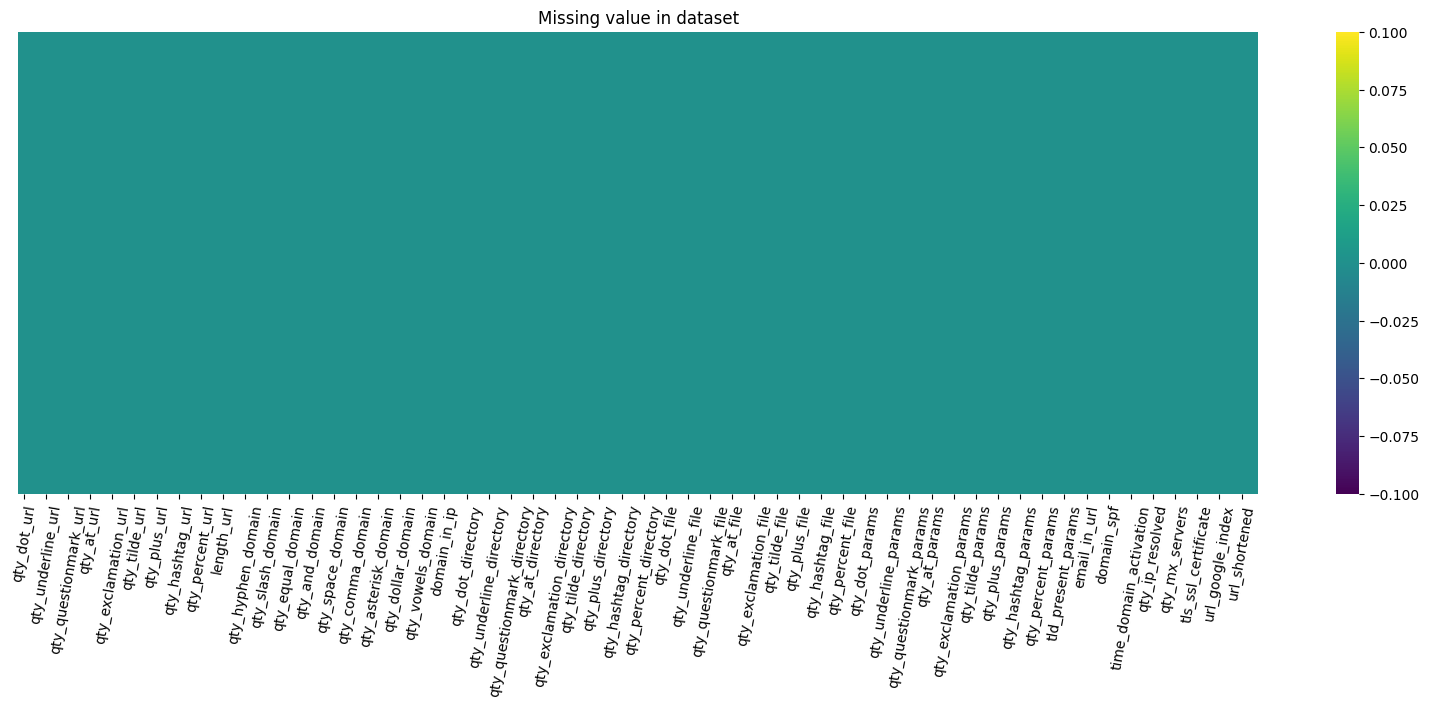

In [5]:
# Check missing value
plt.figure(figsize=(20, 6))
sns.heatmap(dataset.isnull(), yticklabels=False, cbar=True, cmap="viridis")
plt.title("Missing value in dataset")
plt.xticks(rotation=80)
plt.show()

Total 0 : 58000
Total 1 : 30647


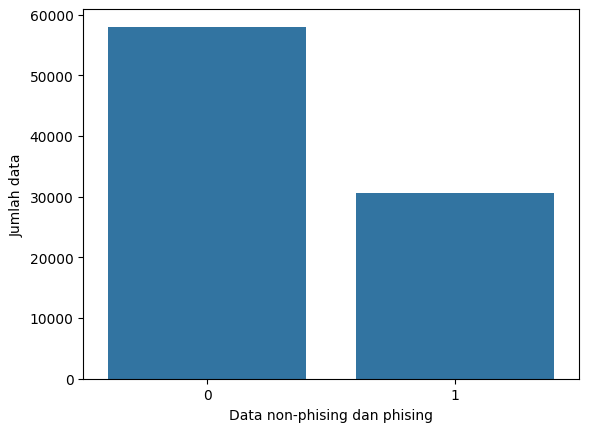

In [6]:
# Checking the distribution of the target variable
phishing_data = dataset['phishing'].value_counts()

sns.countplot(x='phishing', data=dataset)
plt.xticks(ticks=phishing_data.index, labels=phishing_data.index)

plt.xlabel("Data non-phising dan phising")
plt.ylabel("Jumlah data")

print(f"Total 0 : {phishing_data.sum() - dataset['phishing'].sum()}")
print(f"Total 1 : {dataset['phishing'].sum()}")

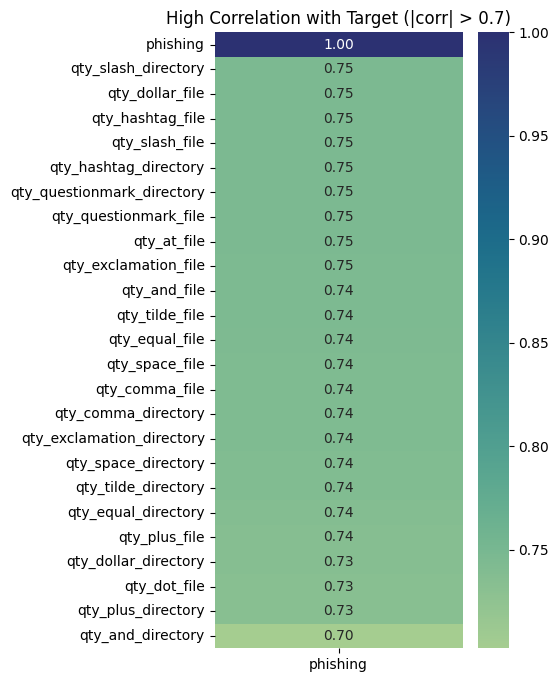

Features Count: 25


In [7]:
# Menghitung korelasi antar fitur
corr = dataset.corr().sort_values('phishing', ascending=False)

# Menampilkan korelasi dengan target, misalnya 'target_column'
target_corr = corr['phishing']

high_corr = target_corr[abs(target_corr) > 0.7]

# Plot heatmap untuk korelasi tinggi
plt.figure(figsize=(4, 8))
sns.heatmap(high_corr.to_frame(), annot=True, cmap="crest", fmt=".2f", cbar=True)
plt.title("High Correlation with Target (|corr| > 0.7)")
plt.show()
print(f'Features Count: {len(high_corr.index.to_list())}')

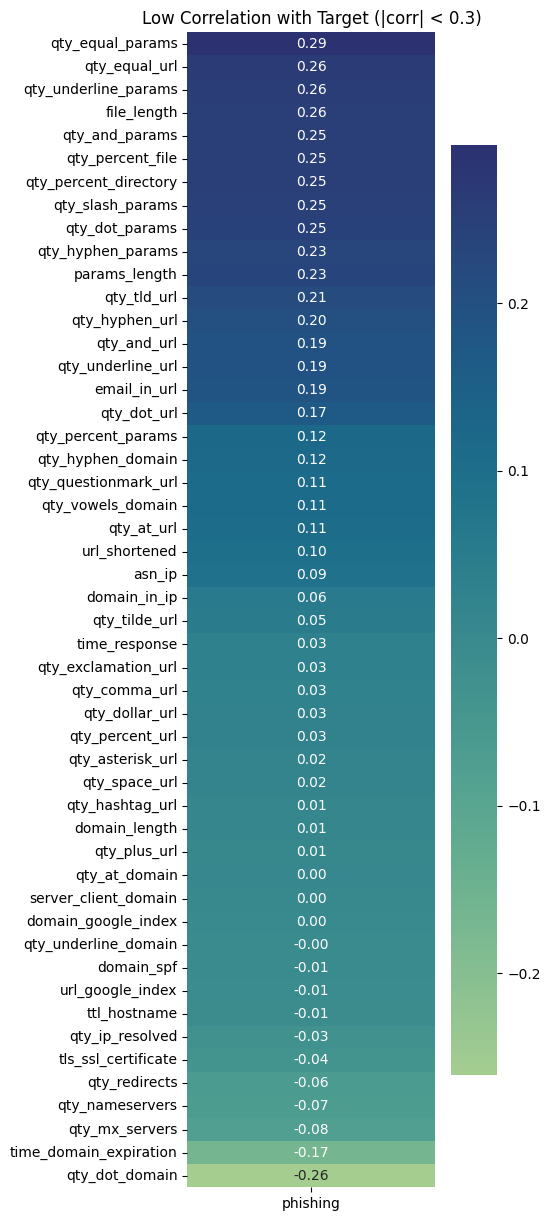

Features Count: 50


In [8]:
corr = dataset.corr().sort_values('phishing', ascending=False)

target_corr = corr['phishing']

low_corr = target_corr[abs(target_corr) < 0.3]

plt.figure(figsize=(4, 15))
sns.heatmap(low_corr.to_frame(), annot=True, cmap="crest", fmt=".2f", cbar=True)
plt.title("Low Correlation with Target (|corr| < 0.3)")
plt.show()
print(f'Features Count: {len(low_corr.index.to_list())}')

# 3. Data Preprocessing

In [9]:
# Handle Outliers
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=20)
dataset['outlier'] = lof.fit_predict(dataset)

# Outliers Detected by LOF Algorithm (outlier = -1)
outliers = dataset[dataset['outlier'] == -1]
print("Outliers Detected:")
outliers


Outliers Detected:


,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,...,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened,phishing,outlier
5,1,0,0,2,0,0,0,0,0,0,...,3,3,3591,1,0,0,0,0,1,-1
14,3,0,0,2,0,0,0,0,0,0,...,2,2,-1,0,0,0,0,0,1,-1
23,2,0,0,0,0,0,0,0,0,0,...,2,1,291,0,1,0,0,0,0,-1
40,2,0,0,0,0,0,0,0,0,0,...,2,1,2901,1,1,0,0,0,0,-1
49,2,3,0,5,0,0,0,0,0,0,...,4,1,87,1,0,0,0,0,1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88600,1,0,0,0,0,0,0,0,0,0,...,2,1,14379,0,-1,0,0,0,0,-1
88601,2,0,0,1,0,0,0,0,0,0,...,4,5,291,0,0,0,0,0,1,-1
88610,2,1,0,5,0,0,0,0,0,0,...,2,1,4817,1,1,0,0,0,1,-1
88616,1,0,0,0,0,0,0,0,0,0,...,4,1,5366,1,1,0,0,0,0,-1


In [10]:
# Remove Outliers
dataset = dataset[dataset['outlier'] != -1]
dataset.drop(columns=['outlier'], inplace=True)
dataset

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,...,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened,phishing
0,3,0,0,1,0,0,0,0,0,0,...,1,2,0,892,0,0,0,0,0,1
1,5,0,1,3,0,3,0,2,0,0,...,1,2,1,9540,1,0,0,0,0,1
2,2,0,0,1,0,0,0,0,0,0,...,1,2,3,589,1,0,0,0,0,0
3,4,0,2,5,0,0,0,0,0,0,...,1,2,0,292,1,0,0,0,0,1
4,2,0,0,0,0,0,0,0,0,0,...,1,2,1,3597,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88642,3,1,0,0,0,0,0,0,0,0,...,1,3,1,3597,0,0,0,0,0,0
88643,2,0,0,0,0,0,0,0,0,0,...,1,2,2,591,0,2,0,0,0,0
88644,2,1,0,5,0,0,0,0,0,0,...,1,2,5,14391,1,0,0,0,0,1
88645,2,0,0,1,0,0,0,0,0,0,...,1,1,1,52,1,0,0,0,0,1


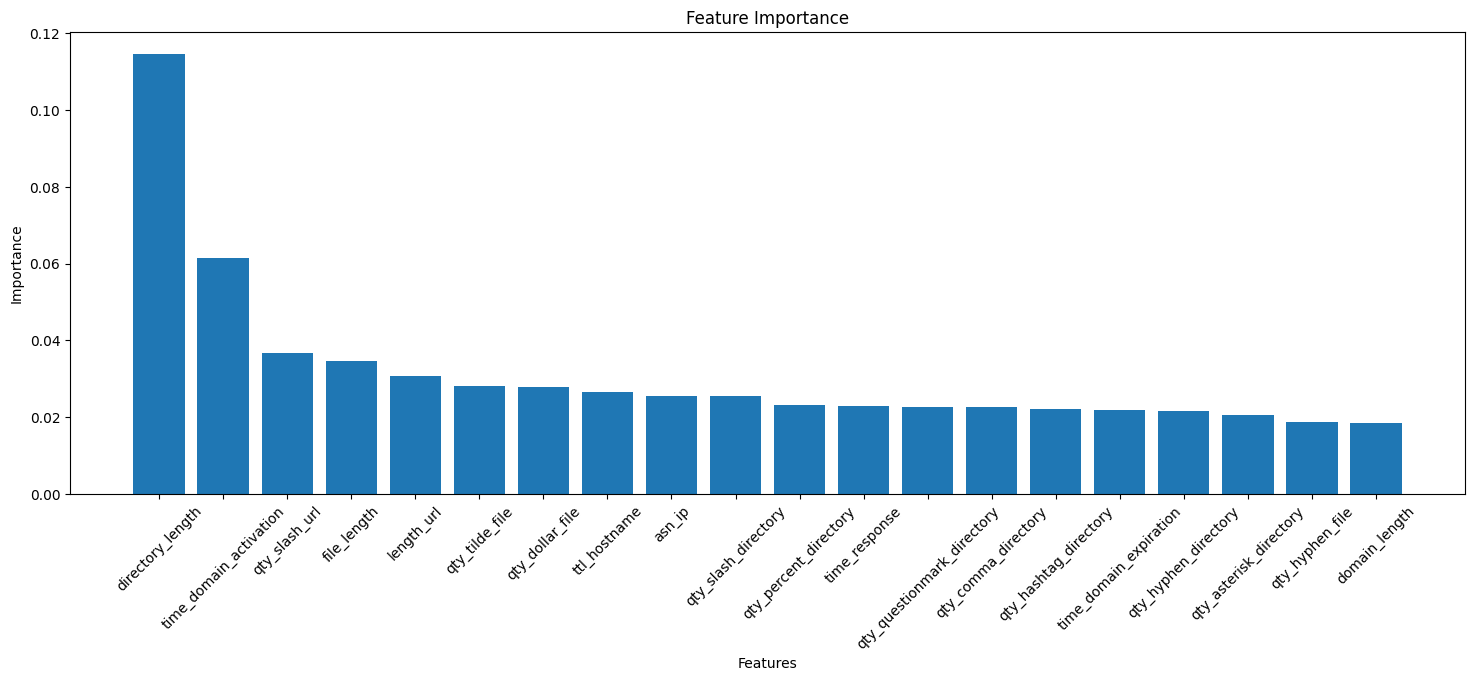

In [11]:
# Search for the best features using Random Forest
k = 20 # @param {type: "number"}

X = dataset.drop(columns=['phishing'])
y = dataset['phishing']

model = RandomForestClassifier()
model.fit(X, y)
importances = model.feature_importances_

# Urutkan fitur berdasarkan pentingnya
indices = importances.argsort()[::-1]
X_new = X.iloc[:, indices[:k]]

# Membuat plot untuk feature importance
plt.figure(figsize=(18, 6))
plt.title("Feature Importance")
plt.bar(range(X_new.shape[1]), importances[indices[:k]], align="center")
plt.xticks(range(X_new.shape[1]), X_new.columns, rotation=45)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()



In [12]:
for x in X_new.columns.tolist():
  print(x)

directory_length
time_domain_activation
qty_slash_url
file_length
length_url
qty_tilde_file
qty_dollar_file
ttl_hostname
asn_ip
qty_slash_directory
qty_percent_directory
time_response
qty_questionmark_directory
qty_comma_directory
qty_hashtag_directory
time_domain_expiration
qty_hyphen_directory
qty_asterisk_directory
qty_hyphen_file
domain_length


In [13]:
# @title Mengambil fitur yang diperlukan
X = X_new

dataset = pd.concat([X, y], axis=1)
dataset.head()

,directory_length,time_domain_activation,qty_slash_url,file_length,length_url,qty_tilde_file,qty_dollar_file,ttl_hostname,asn_ip,qty_slash_directory,...,time_response,qty_questionmark_directory,qty_comma_directory,qty_hashtag_directory,time_domain_expiration,qty_hyphen_directory,qty_asterisk_directory,qty_hyphen_file,domain_length,phishing
0,8,-1,1,7,25,0,0,892,60781,1,...,0.207316,0,0,0,-1,0,0,0,17,1
1,42,579,3,9,223,0,0,9540,36024,3,...,0.499566,0,0,0,150,0,0,0,16,1
2,1,-1,1,0,15,0,0,589,4766,1,...,0.935901,0,0,0,-1,0,0,0,14,0
3,62,-1,5,9,81,0,0,292,20454,5,...,0.410021,0,0,0,-1,0,0,0,19,1
4,-1,6998,0,-1,19,-1,-1,3597,53831,-1,...,0.410761,-1,-1,-1,306,-1,-1,-1,19,0


In [14]:
dataset.shape

(76951, 21)

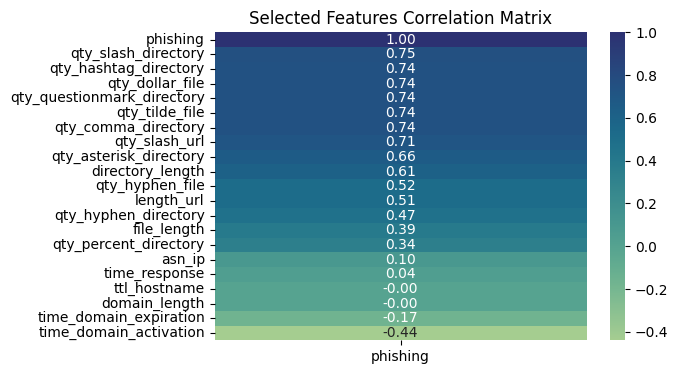

Features Count: 20


In [15]:
# Korelasi
corr = dataset.corr().sort_values(by='phishing', ascending=False)

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr['phishing'].to_frame(), annot=True, cmap="crest", fmt=".2f")
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.title("Selected Features Correlation Matrix")
plt.show()

print(f"Features Count: {len(X.columns)}")

# 4. Splitting Dataset

In [16]:
X = dataset.drop(columns=['phishing'])
y = dataset['phishing']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Banyak data train : {X_train.shape[0]}")
print(f"Banyak data test : {X_test.shape[0]}")

Banyak data train : 53865
Banyak data test : 23086


# 5. Model Selection & Implementation

## 5.1 K-Nearest Neighbors

In [17]:
# @title Making the model with **K-Nearest Neighbors**
classifier_knn = KNeighborsClassifier(n_neighbors=5)
classifier_knn.fit(X_train.values, y_train.values.ravel())
y_pred_knn = classifier_knn.predict(X_test.values)

In [18]:
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91     15337
           1       0.82      0.81      0.82      7749

    accuracy                           0.88     23086
   macro avg       0.86      0.86      0.86     23086
weighted avg       0.88      0.88      0.88     23086



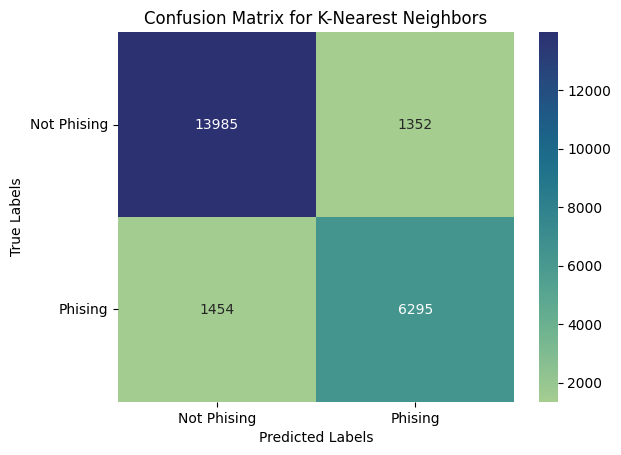

In [19]:
cm_knn = confusion_matrix(y_test, y_pred_knn)

plot_confusion_matrix(cm_knn, title="K-Nearest Neighbors")

In [20]:

accuracy_list.loc[accuracy_list['algorithm'] == 'K-Nearest Neighbors', 'accuracy'] = accuracy_score(y_test, y_pred_knn)

print(f"KNN accuracy : {accuracy_score(y_test, y_pred_knn)}")

KNN accuracy : 0.8784544745733345


## 5.2 Logistical Regression

In [21]:
# @title Making the model with **Logistical Regression**
classifier_lr = LogisticRegression(max_iter=5000)
classifier_lr.fit(X_train.values,y_train.values.ravel())
y_pred_lr = classifier_lr.predict(X_test.values)

C:\Users\thori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [22]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.95      0.92      0.94     15337
           1       0.85      0.91      0.88      7749

    accuracy                           0.92     23086
   macro avg       0.90      0.91      0.91     23086
weighted avg       0.92      0.92      0.92     23086



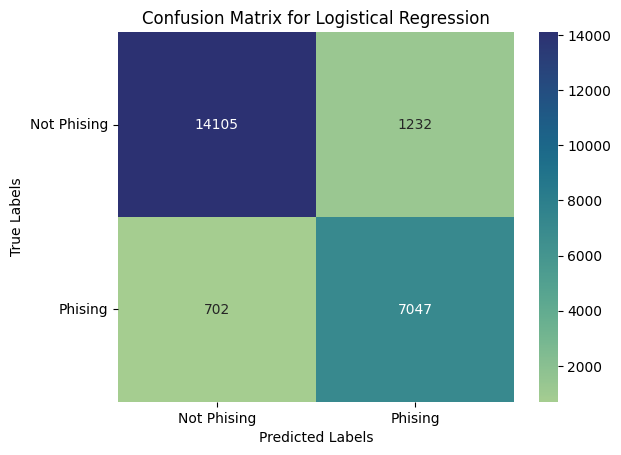

In [23]:
cm_lr = confusion_matrix(y_test, y_pred_lr)

plot_confusion_matrix(cm_lr, title="Logistical Regression")

In [24]:
accuracy_list.loc[accuracy_list['algorithm'] == 'Logistical Regression', 'accuracy'] = accuracy_score(y_test, y_pred_lr)

print(f"Logistical Regression accuracy : {accuracy_score(y_test, y_pred_lr)}")

Logistical Regression accuracy : 0.9162262843281642


## 5.3 Naive Bayes Classifier

In [25]:
# @title Making the model with **Naive Bayes Classifier**
classifier_nb = GaussianNB()
classifier_nb.fit(X_train, y_train.values.ravel())
y_pred = classifier_nb.predict(X_test)

In [26]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92     15337
           1       0.88      0.80      0.84      7749

    accuracy                           0.89     23086
   macro avg       0.89      0.87      0.88     23086
weighted avg       0.89      0.89      0.89     23086



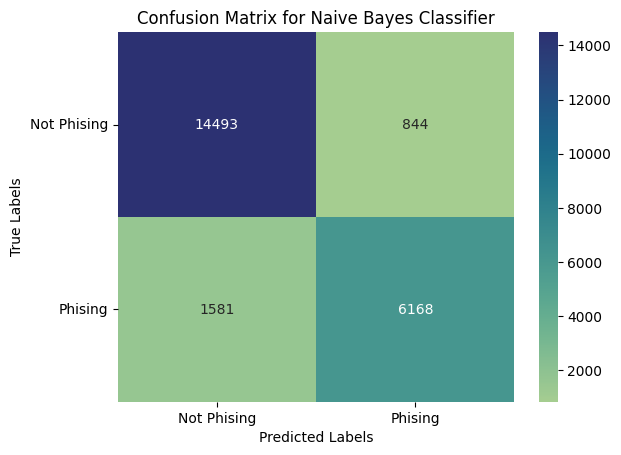

In [27]:
cm_nb = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm_nb, title="Naive Bayes Classifier")

In [28]:
nb_accuracy = accuracy_score(y_test, y_pred)

accuracy_list.loc[accuracy_list['algorithm'] == 'Naive Bayes Classifier', 'accuracy'] = nb_accuracy

print(f"Naive Bayes Classifier accuracy : {nb_accuracy}")


Naive Bayes Classifier accuracy : 0.8949579831932774


## 5.4 Decision Tree

In [29]:
# @title Making the model with **Decision Tree**
classifier_dt = tree.DecisionTreeClassifier(max_depth=7)
classifier_dt.fit(X_train.values,y_train.values)
y_pred_dt = classifier_dt.predict(X_test.values)

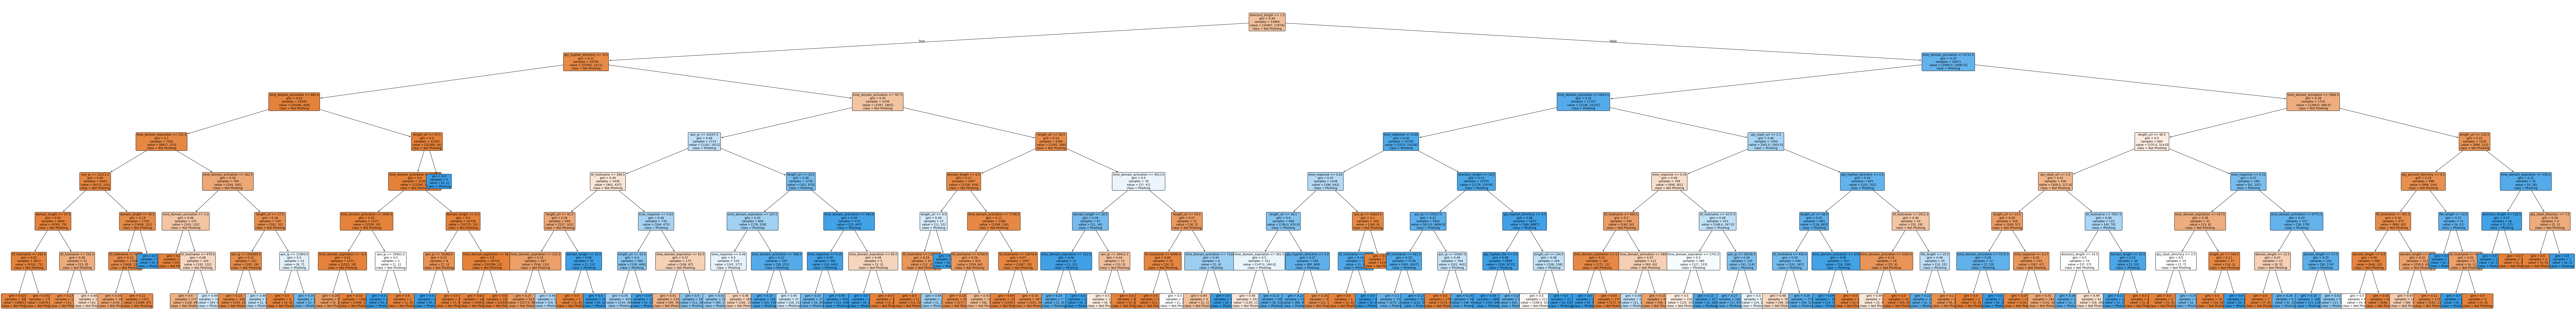

In [30]:
plt.figure(figsize=(160, 20))
tree.plot_tree(
  classifier_dt,
  feature_names=list(X),
  class_names=['Not Phishing', 'Phishing'],
  filled=True,
  rounded=True,
  fontsize=10,
  precision=2
)
plt.show()

In [31]:
print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     15337
           1       0.92      0.93      0.92      7749

    accuracy                           0.95     23086
   macro avg       0.94      0.94      0.94     23086
weighted avg       0.95      0.95      0.95     23086



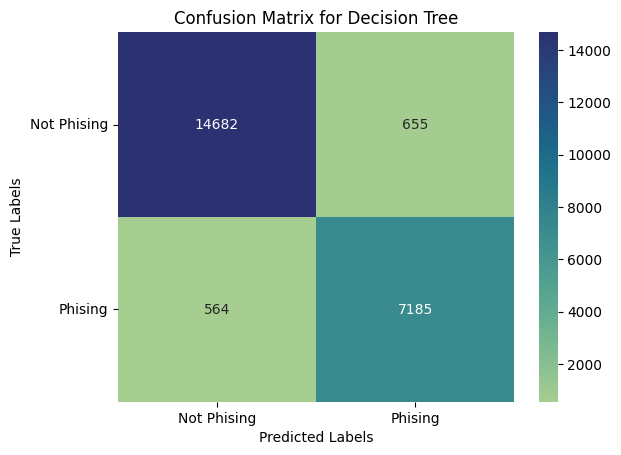

In [32]:
cm_dt = confusion_matrix(y_test, y_pred_dt)
plot_confusion_matrix(cm_dt, title="Decision Tree")

In [33]:
accuracy_list.loc[accuracy_list['algorithm'] == 'Decision Tree', 'accuracy'] = accuracy_score(y_test, y_pred_dt)
print(f"Decision Tree accuracy : {accuracy_score(y_test, y_pred_dt)}")

Decision Tree accuracy : 0.947197435675301


## 5.5 Random Forest

In [34]:
# @title Making the model with **Random Forest**
classifier_rf = RandomForestClassifier(n_estimators=200)
classifier_rf.fit(X_train.values,y_train.values.ravel())
y_pred_rf = classifier_rf.predict(X_test.values)

In [35]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97     15337
           1       0.95      0.95      0.95      7749

    accuracy                           0.97     23086
   macro avg       0.96      0.96      0.96     23086
weighted avg       0.97      0.97      0.97     23086



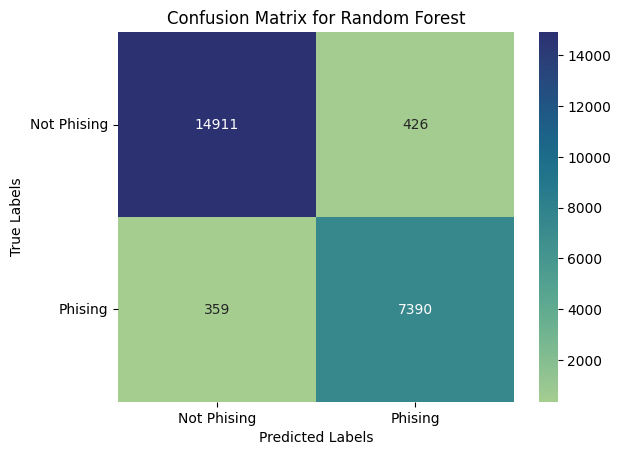

In [36]:
cm_rf = confusion_matrix(y_test, y_pred_rf)

plot_confusion_matrix(cm_rf, title="Random Forest")

In [37]:
accuracy_list.loc[accuracy_list['algorithm'] == 'Random Forest', 'accuracy'] = accuracy_score(y_test, y_pred_rf)

print(f"Random Forest accuracy : {accuracy_score(y_test, y_pred_rf)}")

Random Forest accuracy : 0.9659967079615351


# 6. Model Evaluation

In [38]:
accuracy_list.sort_values(by='accuracy', ascending=False)

,algorithm,accuracy
4,Random Forest,0.965997
3,Decision Tree,0.947197
1,Logistical Regression,0.916226
2,Naive Bayes Classifier,0.894958
0,K-Nearest Neighbors,0.878454


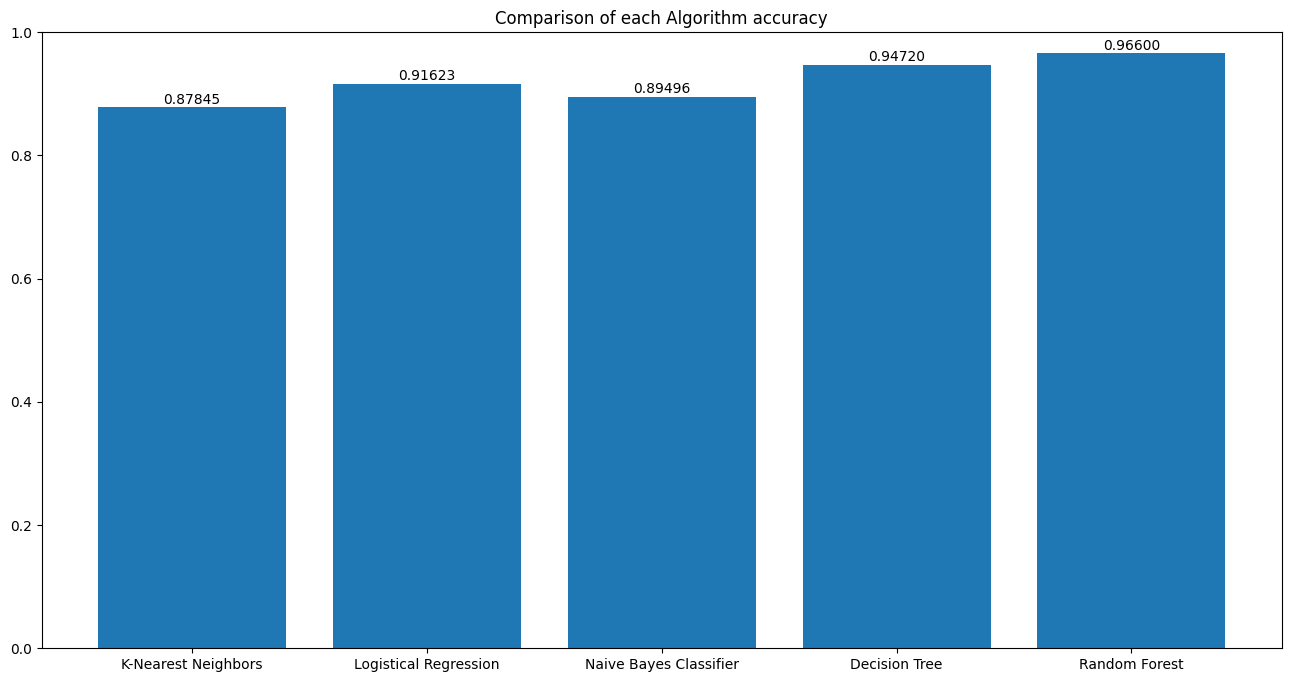

In [39]:
plt.figure(figsize=(16,8))
bars = plt.bar(accuracy_list['algorithm'], accuracy_list['accuracy'])
plt.ylim(0, 1)
plt.title("Comparison of each Algorithm accuracy")

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.001, f'{yval:.5f}', ha='center', va='bottom')

plt.show()

In [40]:
# Testing the model with new data
test_dataset = pd.read_csv("./dataset/dataset_url_only.csv")

# Select relevant columns
test_dataset = test_dataset[['url', 'type']]

# Remove rows where type is 'defacement' or 'malware'
test_dataset = test_dataset[~test_dataset['type'].isin(['defacement', 'malware'])]

# Replace 'benign' with 0 and 'phishing' with 1
test_dataset['type'] = test_dataset['type'].map({'benign': 0, 'phishing': 1})

test_dataset.describe()


,type
count,522214.000000
mean,0.180215
std,0.384367
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [41]:
# Filter rows with type '0' (benign)
benign_urls = test_dataset[test_dataset['type'] == 0]

# Check if there are at least 35,000 benign rows
if len(benign_urls) >= 300000:
    # Randomly select 35,000 rows to drop from the benign URLs
    rows_to_drop = benign_urls.sample(300000, random_state=42)
    
    # Drop the selected rows from the original dataset
    test_dataset = test_dataset.drop(rows_to_drop.index)

else:
    print("Not enough benign URLs to drop")

# Display the updated dataset
test_dataset

,url,type
0,br-icloud.com.br,1
6,espn.go.com/nba/player/_/id/3457/brandon-rush,0
9,allmusic.com/album/crazy-from-the-heat-r16990,0
21,signin.eby.de.zukruygxctzmmqi.civpro.co.za,1
23,nytimes.com/1998/03/29/style/cuttings-oh-that-...,0
...,...,...
651186,xbox360.ign.com/objects/850/850402.html,1
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,1
651188,www.gamespot.com/xbox360/action/deadspace/,1
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),1


Total 0 : 128103
Total 1 : 94111


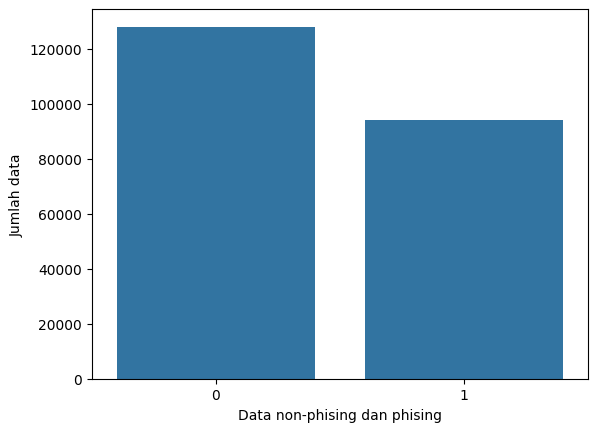

In [42]:
phishing_data = test_dataset['type'].value_counts()

sns.countplot(x='type', data=test_dataset)
plt.xticks(ticks=phishing_data.index, labels=phishing_data.index)

plt.xlabel("Data non-phising dan phising")
plt.ylabel("Jumlah data")

print(f"Total 0 : {phishing_data.sum() - test_dataset['type'].sum()}")
print(f"Total 1 : {test_dataset['type'].sum()}")

## Testing with Out-Domain dataset

In [64]:
n = 5  # @param {type:"integer"}
test_sample = test_dataset.sample(n)

for url, type in zip(test_sample['url'], test_sample['type']):
    print(f"URL: {url}")
    print(f"Actual Type: {'Phishing' if type == 1 else 'Benign'}")
    print()

URL: http://www.bccplanning.com/css/.css/aguard.php
Actual Type: Phishing

URL: tools.ietf.org/html/rfc1710
Actual Type: Phishing

URL: www.xmission.com/~callahan/plug-ins/genetic.html
Actual Type: Phishing

URL: bde1wtzxfho2d9krz0ar.viomil.ro
Actual Type: Phishing

URL: w3.yuchengtech.com/video/www.paypal.co.uk/
Actual Type: Benign



In [65]:
# Initialize the list to store the results
features_list = []
predictions = []  # Store all predictions in a list
true_labels = []  # Store all true labels in a list
all_features = []  # Store all features in a list

# Loop through each URL in the test_sample['url'] and extract features
for url in test_sample['url']:
    # Extract features for each URL
    features = extract_features(url)
    
    # Convert the feature dictionary into a DataFrame (one row)
    features_df = pd.DataFrame([features])  # One row with features
    features_df = features_df.applymap(lambda x: float(x) if isinstance(x, (int, float)) else 0)

    all_features.append(features_df)
    
    # Predict using the classifier
    test_predictions = classifier_rf.predict(features_df.values)[0]
    
    # Get the true label for the URL
    true_label = test_sample.loc[test_sample['url'] == url, 'type'].values[0]
    
    # Store the URL, true label, and prediction
    predictions.append(test_predictions)
    true_labels.append(true_label)
    features_list.append([url, true_label, test_predictions])  # Optional: Storing URL, true_label, and prediction

# Combine all feature DataFrames into a single DataFrame
all_features_df = pd.concat(all_features, ignore_index=True)
all_features_df

Failed to resolve domain: www.bccplanning.com
Failed to fetch TTL for domain: www.bccplanning.com
Error fetching ASN for IP: [Errno 11001] getaddrinfo failed
Failed to get response from URL: http://www.bccplanning.com/css/.css/aguard.php
Failed to fetch domain expiration for www.bccplanning.com: No match for "BCCPLANNING.COM".
>>> Last update of whois database: 2024-12-08T04:07:59Z <<<

NOTICE: The expiration date displayed in this record is the date the
registrar's sponsorship of the domain name registration in the registry is
currently set to expire. This date does not necessarily reflect the expiration
date of the domain name registrant's agreement with the sponsoring
registrar.  Users may consult the sponsoring registrar's Whois database to
view the registrar's reported date of expiration for this registration.

TERMS OF USE: You are not authorized to access or query our Whois
database through the use of electronic processes that are high-volume and
automated except as reasonably n

,time_domain_activation,ttl_hostname,asn_ip,directory_length,qty_questionmark_file,qty_space_directory,qty_slash_directory,file_length,length_url,qty_dot_file,time_response,qty_hyphen_file,time_domain_expiration,qty_space_file,qty_exclamation_directory,qty_hashtag_directory,qty_slash_url,qty_hyphen_directory,domain_length,qty_underline_file
0,0.000000,0.0,0.0,3.0,0.0,0.0,3.0,10.0,46.0,1.0,0.000000,0.0,0.000000e+00,0.0,0.0,0.0,5.0,0.0,19.0,0.0
1,0.021641,600.0,13335.0,2.0,0.0,0.0,2.0,7.0,34.0,0.0,1.160815,0.0,3.963550e+07,0.0,0.0,0.0,4.0,0.0,14.0,0.0
2,0.470911,3600.0,6315.0,3.0,0.0,0.0,3.0,12.0,55.0,1.0,2.420297,0.0,4.084148e+07,0.0,0.0,0.0,5.0,1.0,16.0,0.0
3,0.029215,3600.0,63859.0,1.0,0.0,0.0,0.0,0.0,37.0,0.0,5.098337,0.0,0.000000e+00,0.0,0.0,0.0,2.0,0.0,30.0,0.0
4,0.464798,600.0,46844.0,2.0,0.0,0.0,3.0,0.0,49.0,0.0,0.727133,0.0,2.184844e+07,0.0,0.0,0.0,5.0,0.0,18.0,0.0


In [66]:
# Create a DataFrame from the results list
results = pd.DataFrame(features_list, columns=['url', 'true_label', 'prediction'])

# Show the final results
results

,url,true_label,prediction
0,http://www.bccplanning.com/css/.css/aguard.php,1,0
1,tools.ietf.org/html/rfc1710,1,1
2,www.xmission.com/~callahan/plug-ins/genetic.html,1,0
3,bde1wtzxfho2d9krz0ar.viomil.ro,1,0
4,w3.yuchengtech.com/video/www.paypal.co.uk/,0,1


In [67]:
print(classification_report(true_labels, predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.50      0.25      0.33         4

    accuracy                           0.20         5
   macro avg       0.25      0.12      0.17         5
weighted avg       0.40      0.20      0.27         5



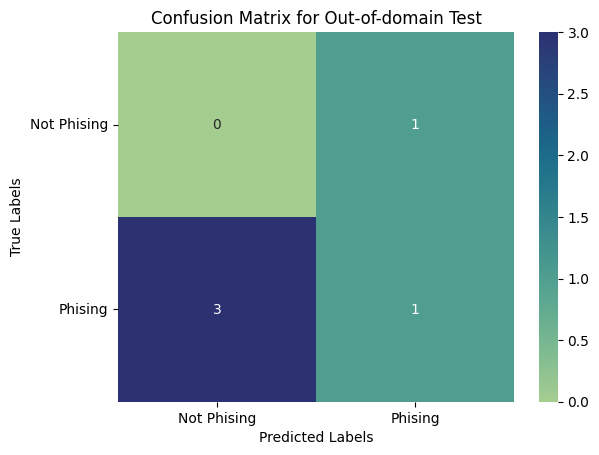

In [68]:
cm_test = confusion_matrix(true_labels, predictions)

plot_confusion_matrix(cm_test, title="Out-of-domain Test")

# 7. Conclusion & Deployment

In [69]:
dump(classifier_rf, './app/model/url_classification_rf.joblib')

['./app/model/url_classification_rf.joblib']

# References
- [urls-classification(burusbetulcavusoglu)](https://www.kaggle.com/code/busrabetulcavusoglu/urls-classification)
- [Kagglehub](https://github.com/Kaggle/kagglehub)